In [1]:
import os
import sys

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"

module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import numpy as np
import torch
from skimage import measure
from tqdm import tqdm, trange

from core.dataset import ScanNet
from core.integrate import FeatureFusionScalableTSDFVolume, ScalableTSDFVolume
from core.integrate.utils import discrete2hash, discrete2world, discretize_3d, hash2discrete

from temp import build_depth_from_voxel, pixel_dense_voxel_projection

In [3]:
dataset = ScanNet('/home/quanta/Datasets/ScanNet/')
scan_id = 'scene0000_00'
id = dataset.scan_id_list.index(scan_id)
single_instance = dataset[id]['scan_dataset']

In [4]:
H, W = single_instance.color_height, single_instance.color_width

In [5]:
tsdf_device = 'cuda:1'
tsdf_volume = FeatureFusionScalableTSDFVolume(
    voxel_size=0.015,
    sdf_trunc=0.075,
    margin=0.08,
    device=tsdf_device,
)


In [6]:
save_dir = '/home/quanta/Experiments/feature-instance-fusion/scannet_scene0000_00/'
tsdf_volume.load(save_dir + 'tsdf/tsdf_vol.pt')

In [14]:
indent = 1
# for idx in trange(0, len(single_instance), indent):
for idx in trange(1):
    idx = 4650
    inputs = single_instance.get_torch_tensor(
        idx,
        device=tsdf_device,
        keys={
            "depth",
            "depth_intr",
            "pose",
            "color_intr",
            "color",
        },
    )

100%|██████████| 1/1 [00:00<00:00, 30.18it/s]


In [18]:
%%time
depth = build_depth_from_voxel(
    cam_pose=inputs["pose"],
    cam_intr=inputs["color_intr"],
    voxel_hash=tsdf_volume._voxel_hash,
    voxel_size=tsdf_volume.voxel_size,
    voxel_origin=tsdf_volume._vol_origin,
    H=H,
    W=W,
    pixel_batch_size=50*50,
)

CPU times: user 347 ms, sys: 13.8 ms, total: 361 ms
Wall time: 358 ms


In [19]:
depth[depth > 1e6] = 0.0

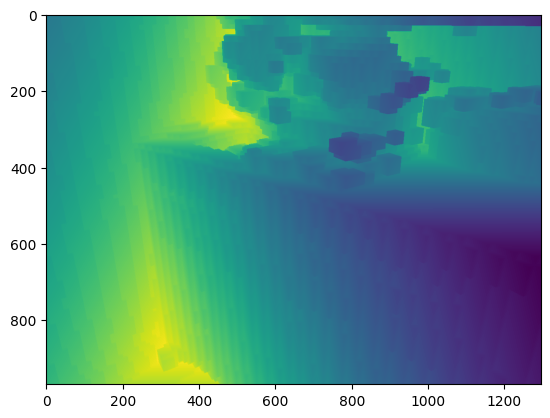

In [20]:
import matplotlib.pyplot as plt

plt.imshow(depth.detach().cpu().numpy())

In [11]:
torch.cuda.empty_cache()

In [12]:
voxel_corres = pixel_dense_voxel_projection(
    cam_pose=inputs["pose"],
    cam_intr=inputs["color_intr"],
    voxel_hash=tsdf_volume._voxel_hash,
    voxel_size=tsdf_volume.voxel_size,
    voxel_origin=tsdf_volume._vol_origin,
    H=H,
    W=W,
    pixel_batch_size=50 * 50,
)

In [13]:
voxel_corres

tensor([4611499102160552131, 4611499102160552132, 4611499102160552133,
         ..., 4614758054348456079, 4614758054350553229,
        4614758054350553230], device='cuda:1')